In [2]:
import sys, platform
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib
try:
    import plotly
    _plotly_ver = plotly.__version__
except Exception:
    _plotly_ver = "not installed"

try:
    import statsmodels as sm
    _sm_ver = sm.__version__
except Exception:
    _sm_ver = "not installed"

print("Python:", sys.version.split()[0])
print("Platform:", platform.platform())
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("matplotlib:", matplotlib.__version__)
print("plotly:", _plotly_ver)
print("statsmodels:", _sm_ver)

WDI_XLSX_PATH = Path("/content/WDIEXCEL.xlsx")
print("\n=== Data File Check ===")
print("Path:", WDI_XLSX_PATH)
print("Exists:", WDI_XLSX_PATH.exists())


Python: 3.12.11
Platform: Linux-6.1.123+-x86_64-with-glibc2.35
pandas: 2.2.2
numpy: 2.0.2
matplotlib: 3.10.0
plotly: 5.24.1
statsmodels: not installed

=== Data File Check ===
Path: /content/WDIEXCEL.xlsx
Exists: True


In [4]:
import importlib, sys, subprocess
pkg = "openpyxl"
spec = importlib.util.find_spec(pkg)
if spec is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
import openpyxl
print(openpyxl.__version__)


3.1.5


In [5]:
from pathlib import Path
import pandas as pd
import numpy as np

xlf = pd.ExcelFile(WDI_XLSX_PATH)
print(xlf.sheet_names)

df_raw = pd.read_excel(xlf, sheet_name="Data")
print(df_raw.shape)
print(list(df_raw.columns[:12]))
print(list(df_raw.columns[-12:]))

ids = ["Country Name","Country Code","Indicator Name","Indicator Code"]
print({k:(k in df_raw.columns) for k in ids})

years = [c for c in df_raw.columns if str(c).isdigit() and len(str(c))==4]
print(len(years))

wdi_long = df_raw.melt(id_vars=ids, value_vars=years, var_name="Year", value_name="Value")
wdi_long["Year"] = pd.to_numeric(wdi_long["Year"], errors="coerce").astype("Int64")
wdi_long["Value"] = pd.to_numeric(wdi_long["Value"], errors="coerce")
wdi_long = wdi_long.dropna(subset=["Value"])

print(wdi_long.shape)
print(wdi_long["Country Code"].nunique())
print(wdi_long["Indicator Code"].nunique())
print(int(wdi_long["Year"].min()), int(wdi_long["Year"].max()))
print(wdi_long.head(10).to_string(index=False))


['Data', 'Country', 'Series', 'country-series', 'series-time', 'footnote']
(403256, 69)
['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967']
['2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
{'Country Name': True, 'Country Code': True, 'Indicator Name': True, 'Indicator Code': True}
65
(8957736, 6)
265
1515
1960 2024
               Country Name Country Code                                                            Indicator Name Indicator Code  Year        Value
Africa Eastern and Southern          AFE             Adolescent fertility rate (births per 1,000 women ages 15-19)    SP.ADO.TFRT  1960 1.357926e+02
Africa Eastern and Southern          AFE                        Age dependency ratio (% of working-age population)    SP.POP.DPND  1960 8.896779e+01
Africa Eastern and Southern          AFE                   Age dependency ratio, old (% of working-age popu

In [6]:
ind_counts = wdi_long.groupby("Indicator Name")["Country Code"].nunique().sort_values(ascending=False)
print(ind_counts.head(15).to_string())

country_counts = wdi_long.groupby("Country Name")["Indicator Code"].nunique().sort_values(ascending=False)
print(country_counts.head(15).to_string())

pivot = wdi_long.pivot_table(index="Year", columns="Indicator Code", values="Value", aggfunc="mean")
print(pivot.shape)
print(pivot.head(10).to_string())


Indicator Name
Population ages 0-14 (% of total population)               265
Life expectancy at birth, male (years)                     265
Life expectancy at birth, total (years)                    265
Death rate, crude (per 1,000 people)                       265
Life expectancy at birth, female (years)                   265
Population ages 05-09, male (% of male population)         265
Population ages 00-04, female (% of female population)     265
Population ages 00-04, male (% of male population)         265
Population ages 05-09, female (% of female population)     265
Population ages 10-14, male (% of male population)         265
Net migration                                              265
Mortality rate, adult, male (per 1,000 male adults)        265
Mortality rate, adult, female (per 1,000 female adults)    265
Population ages 0-14, female (% of female population)      265
Population ages 0-14, female                               265
Country Name
Ghana              1465
Ban

In [7]:
sel_inds = [
    "NY.GDP.PCAP.KD",   # GDP per capita, constant
    "SP.DYN.LE00.IN",   # Life expectancy at birth
    "SP.URB.TOTL.IN.ZS" # Urban population (% of total)
]

subset = wdi_long[wdi_long["Indicator Code"].isin(sel_inds)]
pivot_sel = subset.pivot_table(index=["Country Name","Year"], columns="Indicator Code", values="Value")

print(pivot_sel.shape)
print(pivot_sel.dropna().shape)
print(pivot_sel.head(20).to_string())


(17224, 3)
(13987, 3)
Indicator Code     NY.GDP.PCAP.KD  SP.DYN.LE00.IN  SP.URB.TOTL.IN.ZS
Country Name Year                                                   
Afghanistan  1960             NaN          32.799              8.401
             1961             NaN          33.291              8.684
             1962             NaN          33.757              8.976
             1963             NaN          34.201              9.276
             1964             NaN          34.673              9.586
             1965             NaN          35.124              9.904
             1966             NaN          35.583             10.233
             1967             NaN          36.042             10.570
             1968             NaN          36.510             10.918
             1969             NaN          36.979             11.275
             1970             NaN          37.460             11.643
             1971             NaN          37.932             12.021
            

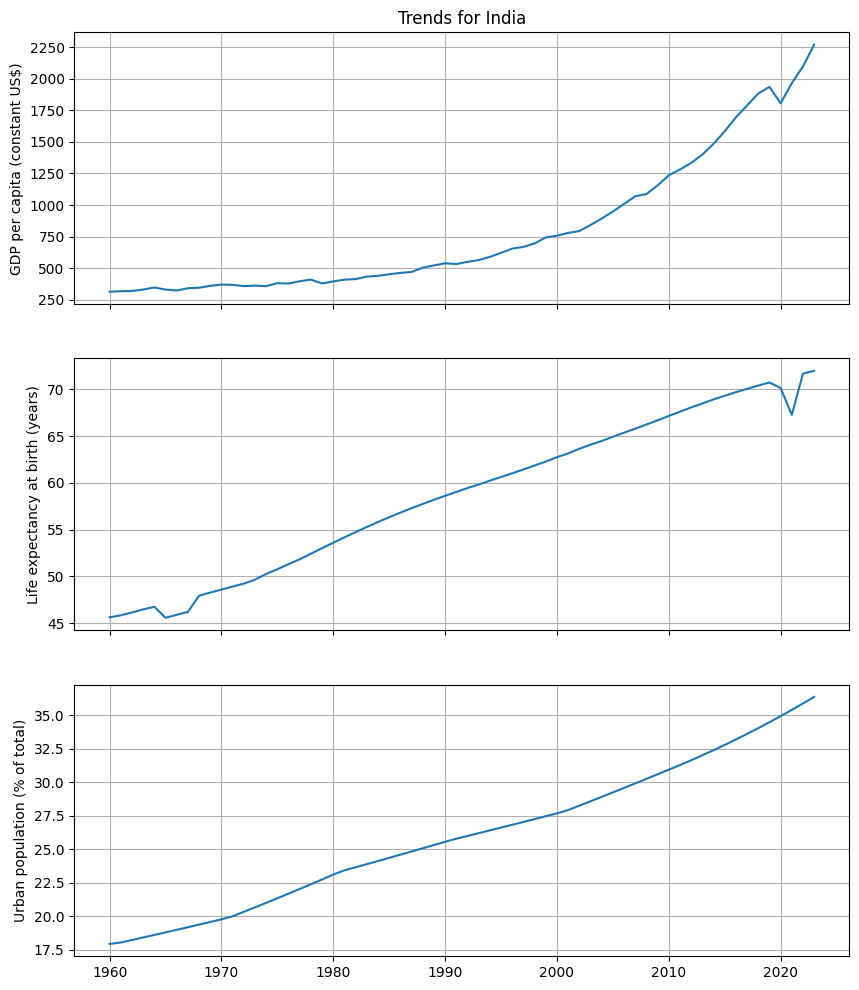

In [8]:
import matplotlib.pyplot as plt

ind_labels = {
    "NY.GDP.PCAP.KD": "GDP per capita (constant US$)",
    "SP.DYN.LE00.IN": "Life expectancy at birth (years)",
    "SP.URB.TOTL.IN.ZS": "Urban population (% of total)"
}

country = "India"
df_country = pivot_sel.loc[country].dropna()

fig, axes = plt.subplots(3,1, figsize=(10,12), sharex=True)
for i, code in enumerate(sel_inds):
    axes[i].plot(df_country.index, df_country[code])
    axes[i].set_ylabel(ind_labels[code])
    axes[i].grid(True)
axes[0].set_title(f"Trends for {country}")
plt.show()


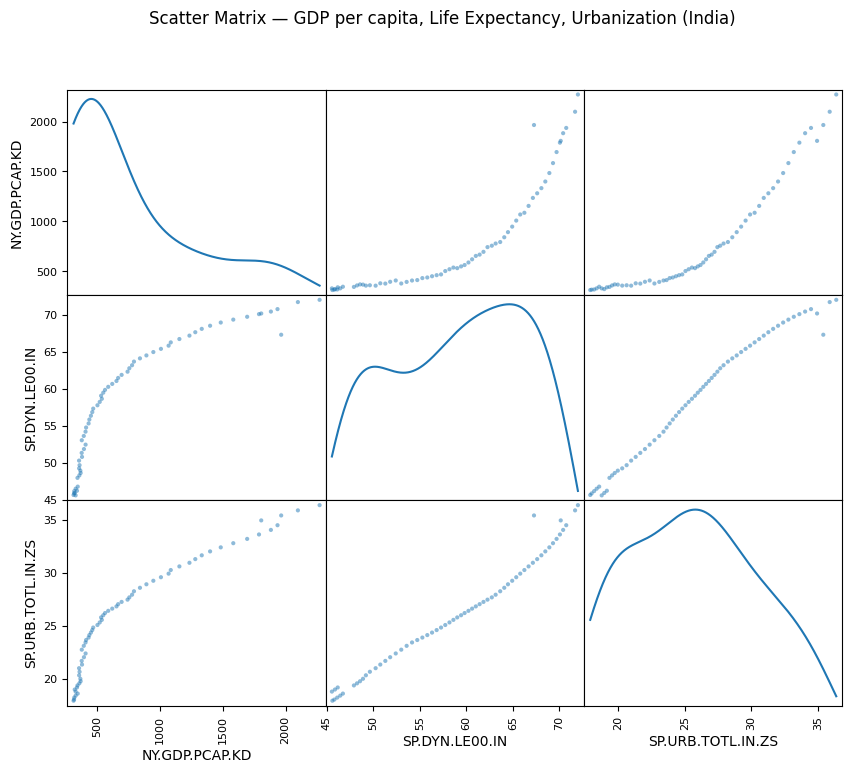

Indicator Code     NY.GDP.PCAP.KD  SP.DYN.LE00.IN  SP.URB.TOTL.IN.ZS
Indicator Code                                                      
NY.GDP.PCAP.KD              1.000           0.876              0.928
SP.DYN.LE00.IN              0.876           1.000              0.988
SP.URB.TOTL.IN.ZS           0.928           0.988              1.000


In [9]:
from pandas.plotting import scatter_matrix

df_country = pivot_sel.loc["India"].dropna()

scatter_matrix(
    df_country,
    figsize=(10,8),
    diagonal="kde",
    alpha=0.5
)
plt.suptitle("Scatter Matrix — GDP per capita, Life Expectancy, Urbanization (India)")
plt.show()

print(df_country.corr().round(3))


In [11]:
import importlib, sys, subprocess
pkg = "statsmodels"
spec = importlib.util.find_spec(pkg)
if spec is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
import statsmodels as sm
print(sm.__version__)


0.14.5


In [12]:
import statsmodels.api as sm

df_country = pivot_sel.loc["India"].dropna()

X = df_country[["SP.DYN.LE00.IN","SP.URB.TOTL.IN.ZS"]]
y = df_country["NY.GDP.PCAP.KD"]

Xc = sm.add_constant(X)
model = sm.OLS(y, Xc).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         NY.GDP.PCAP.KD   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     418.9
Date:                Tue, 16 Sep 2025   Prob (F-statistic):           2.33e-36
Time:                        10:15:31   Log-Likelihood:                -407.29
No. Observations:                  64   AIC:                             820.6
Df Residuals:                      61   BIC:                             827.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               361.0462    273.94

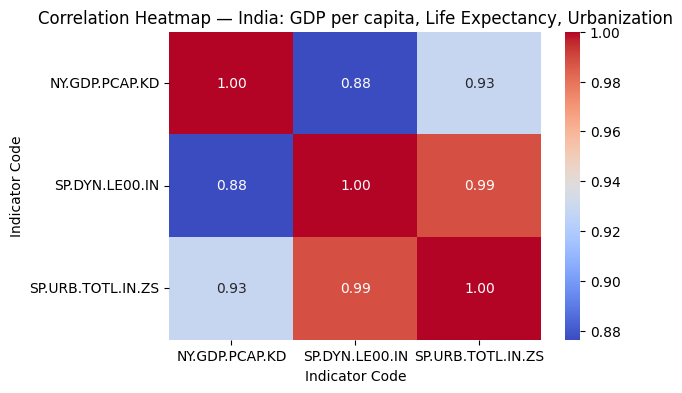

In [13]:
import seaborn as sns

df_country = pivot_sel.loc["India"].dropna()

corr = df_country.corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap — India: GDP per capita, Life Expectancy, Urbanization")
plt.show()


Explained variance ratio: [0.95415927 0.04444715]
Components:
Indicator Code  NY.GDP.PCAP.KD  SP.DYN.LE00.IN  SP.URB.TOTL.IN.ZS
PC1                   0.565245        0.578154           0.588418
PC2                   0.799635       -0.559274          -0.218626


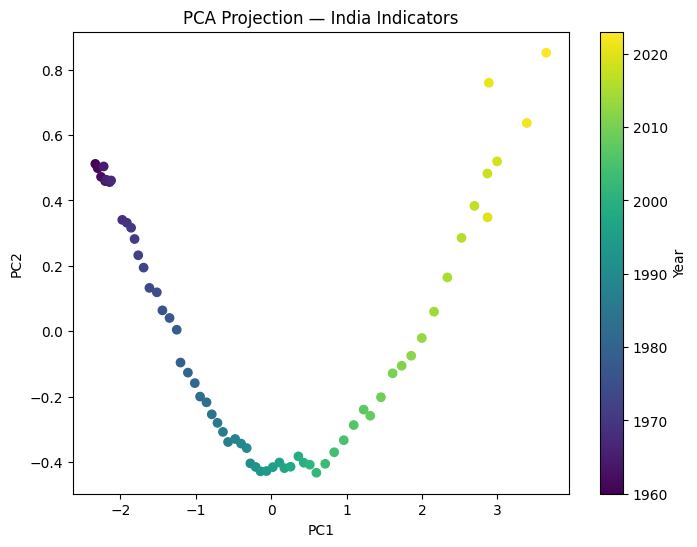

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_country = pivot_sel.loc["India"].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_country)

pca = PCA(n_components=2)
pca_res = pca.fit_transform(X_scaled)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Components:")
print(pd.DataFrame(pca.components_, columns=df_country.columns, index=["PC1","PC2"]))

plt.figure(figsize=(8,6))
plt.scatter(pca_res[:,0], pca_res[:,1], c=df_country.index, cmap="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection — India Indicators")
plt.colorbar(label="Year")
plt.show()


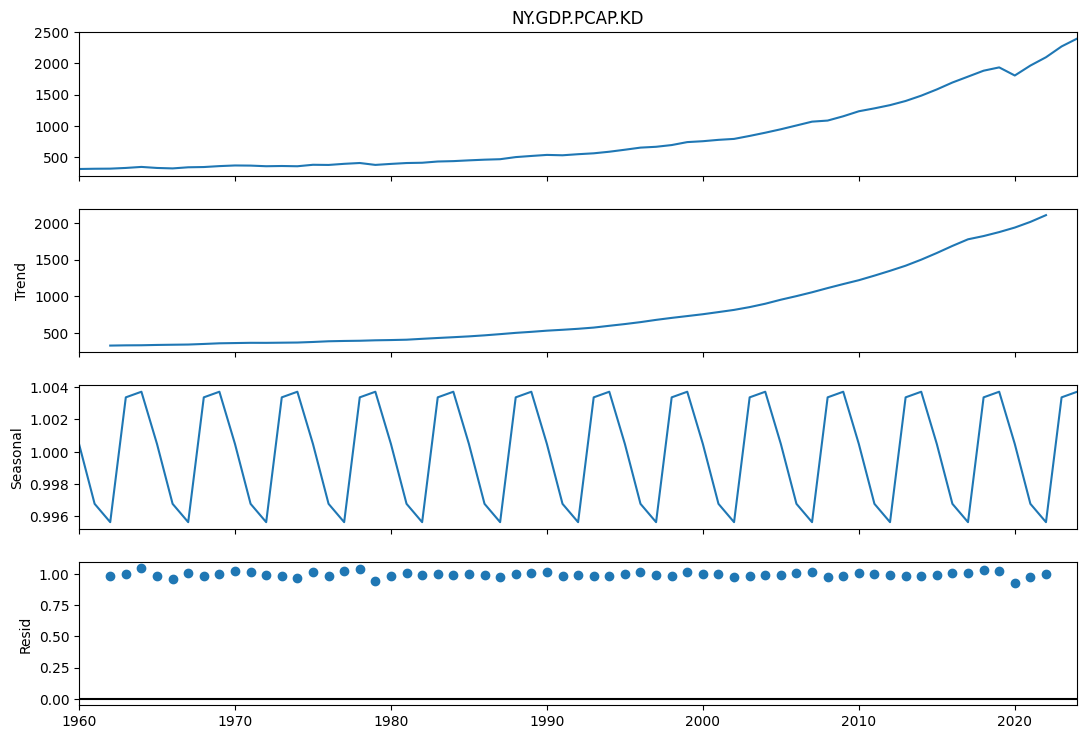

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

series = pivot_sel.loc["India"]["NY.GDP.PCAP.KD"].dropna()

decomp = seasonal_decompose(series, model="multiplicative", period=5)

fig = decomp.plot()
fig.set_size_inches(12,8)
plt.show()


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Usin

                               SARIMAX Results                                
Dep. Variable:         NY.GDP.PCAP.KD   No. Observations:                   65
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -324.907
Date:                Tue, 16 Sep 2025   AIC                            659.814
Time:                        10:17:21   BIC                            670.609
Sample:                             0   HQIC                           664.067
                                 - 65                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9946      1.207      0.824      0.410      -1.371       3.361
ar.L2         -0.0011      1.185     -0.001      0.999      -2.324       2.322
ma.L1         -0.7411      1.279     -0.580      0.5

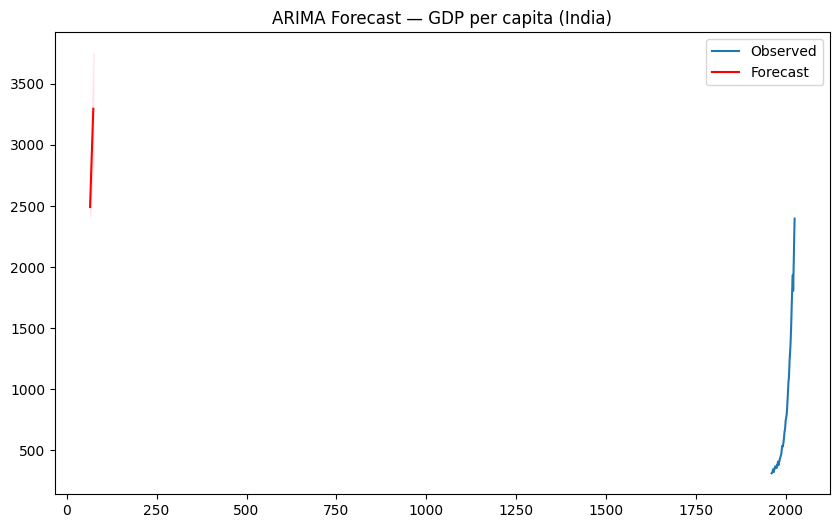

In [16]:
from statsmodels.tsa.arima.model import ARIMA

series = pivot_sel.loc["India"]["NY.GDP.PCAP.KD"].dropna()

model = ARIMA(series, order=(2,1,2))
fit = model.fit()

print(fit.summary())

forecast = fit.get_forecast(steps=10)
pred = forecast.predicted_mean
conf = forecast.conf_int()

plt.figure(figsize=(10,6))
plt.plot(series.index, series, label="Observed")
plt.plot(pred.index, pred, label="Forecast", color="red")
plt.fill_between(conf.index, conf.iloc[:,0], conf.iloc[:,1], color="pink", alpha=0.3)
plt.legend()
plt.title("ARIMA Forecast — GDP per capita (India)")
plt.show()


In [17]:
from statsmodels.tsa.stattools import adfuller

series = pivot_sel.loc["India"]["NY.GDP.PCAP.KD"].dropna()

adf_res = adfuller(series)
print("ADF Statistic:", adf_res[0])
print("p-value:", adf_res[1])
print("Critical Values:")
for k,v in adf_res[4].items():
    print(f"   {k}: {v}")

diff_series = series.diff().dropna()
adf_res2 = adfuller(diff_series)
print("\nAfter 1st differencing")
print("ADF Statistic:", adf_res2[0])
print("p-value:", adf_res2[1])
print("Critical Values:")
for k,v in adf_res2[4].items():
    print(f"   {k}: {v}")



ADF Statistic: 5.543090252048457
p-value: 1.0
Critical Values:
   1%: -3.5443688564814813
   5%: -2.9110731481481484
   10%: -2.5931902777777776

After 1st differencing
ADF Statistic: 2.6453284668049237
p-value: 0.9990821699999624
Critical Values:
   1%: -3.562878534649522
   5%: -2.918973284023669
   10%: -2.597393446745562


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


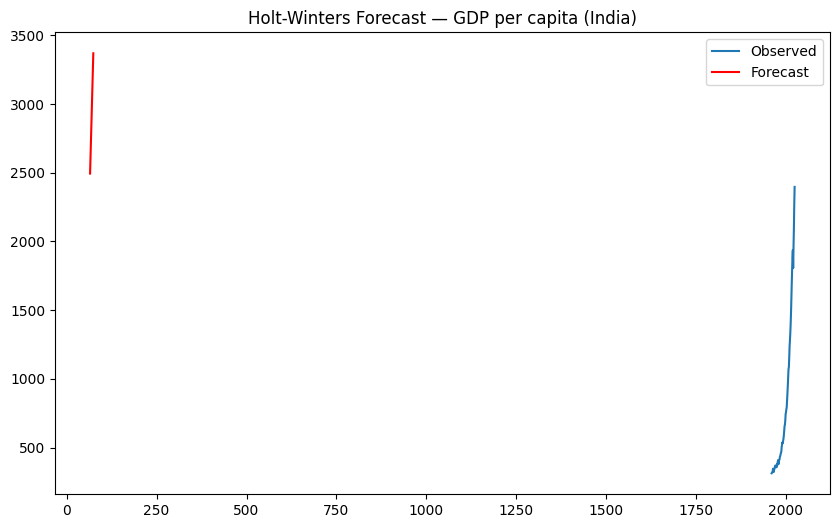

Forecast values:
65    2493.964815
66    2591.216912
67    2688.469009
68    2785.721106
69    2882.973202
70    2980.225299
71    3077.477396
72    3174.729493
73    3271.981590
74    3369.233687
dtype: float64


In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

series = pivot_sel.loc["India"]["NY.GDP.PCAP.KD"].dropna()

model = ExponentialSmoothing(series, trend="add", seasonal=None).fit()
forecast = model.forecast(10)

plt.figure(figsize=(10,6))
plt.plot(series.index, series, label="Observed")
plt.plot(forecast.index, forecast, label="Forecast", color="red")
plt.title("Holt-Winters Forecast — GDP per capita (India)")
plt.legend()
plt.show()

print("Forecast values:")
print(forecast)
